In [7]:
import pandas as pd
import os

# 1. LOAD DATA
print("--- Loading Data ---")

# Load Master Country List (to ensure every country is included)
try:
    original_df = pd.read_csv("text_countries_edited.csv").fillna("")
    # Get unique sorted list of countries
    master_country_list = sorted([c for c in original_df['Country'].unique() if c != ""])
    print(f"Loaded master list: {len(master_country_list)} countries.")
except FileNotFoundError:
    print("Error: 'text_countries_edited.csv' not found.")
    master_country_list = []

# Load Entities Data
try:
    entities_df = pd.read_csv("entities_to_edit.csv").fillna("")
    print(f"Loaded entities: {len(entities_df)} rows.")
except FileNotFoundError:
    print("Error: 'entities_to_edit.csv' not found.")
    entities_df = pd.DataFrame()

# 2. RUN QH CATEGORY ANALYSIS
if not entities_df.empty and master_country_list:
    
    print("\n--- Starting QH Category Analysis (Top Level Only) ---")
    analysis_results = []

    for country in master_country_list:
        # Filter data for this specific country
        country_data = entities_df[entities_df['Country'] == country]
        
        if country_data.empty:
            # CASE: No entities found at all for this country
            analysis_results.append({
                "Country": country,
                "QH_Category": "No Data",
                "Frequency": 0
            })
        else:
            # CASE: Entities exist
            # Group strictly by 'qh_category'
            # dropna=False ensures we count rows even if the category is blank
            counts = country_data.groupby(['qh_category'], dropna=False).size().reset_index(name='Frequency')
            
            # Sort by Frequency (descending)
            counts = counts.sort_values(by='Frequency', ascending=False)
            
            for _, row in counts.iterrows():
                analysis_results.append({
                    "Country": country,
                    "QH_Category": row['qh_category'],
                    "Frequency": row['Frequency']
                })

    # 3. EXPORT
    output_filename = "country_qh_category_analysis.csv"
    final_df = pd.DataFrame(analysis_results)
    
    # Save to CSV
    final_df.to_csv(output_filename, index=False)
    
    print(f"Success! Analysis saved to '{output_filename}'")
    
    # Preview
    print("\nPreview of Analysis:")
    print(final_df.head(10))

else:
    print("\nAnalysis skipped. Please check your input files.")

--- Loading Data ---
Loaded master list: 4 countries.
Loaded entities: 739 rows.

--- Starting QH Category Analysis (Top Level Only) ---
Success! Analysis saved to 'country_qh_category_analysis.csv'

Preview of Analysis:
  Country                    QH_Category  Frequency
0     CAN                     Government         62
1     CAN                   not an actor         57
2     CAN                       Academia         16
3     CAN                  Civil Society          9
4     CAN                  not specified          7
5     CAN                       Industry          6
6     CAN  not relevant (from Footnotes)          2
7     GER                                       301
8     GER                  not specified          2
9      UK                                       212


Loaded entities: 739 rows.
Rows before filter: 739
Rows after filter:  93


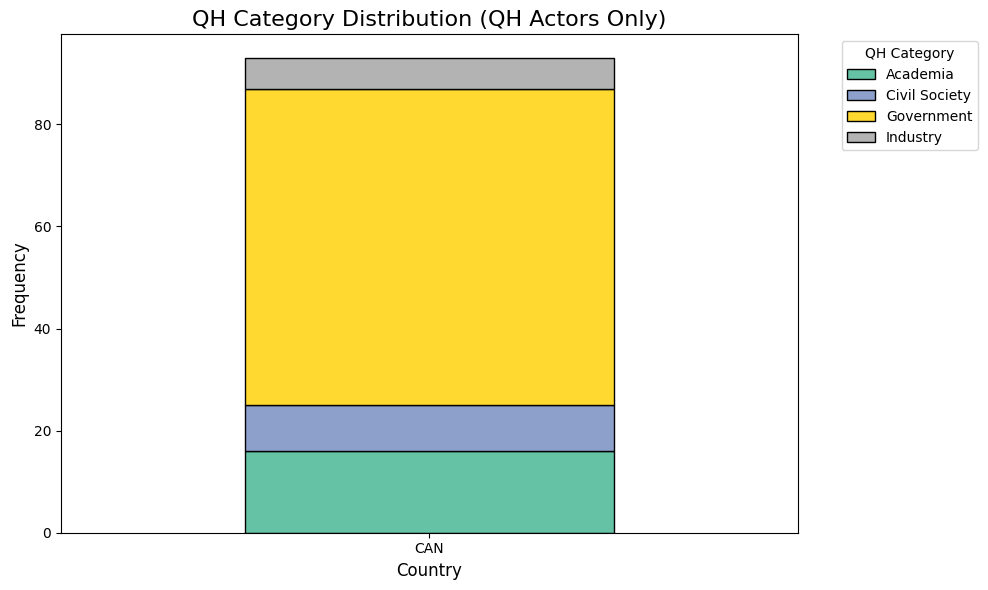

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. LOAD DATA
try:
    entities_df = pd.read_csv("entities_to_edit.csv")
    print(f"Loaded entities: {len(entities_df)} rows.")
except FileNotFoundError:
    print("Error: 'entities_to_edit.csv' not found.")
    entities_df = pd.DataFrame()

if not entities_df.empty:
    # 2. FILTER FOR QH ACTORS ONLY
    # We define the standard actors. Any row not matching these is dropped.
    valid_qh_actors = ['Academia', 'Government', 'Industry', 'Civil Society']
    
    filtered_df = entities_df[entities_df['qh_category'].isin(valid_qh_actors)].copy()
    
    print(f"Rows before filter: {len(entities_df)}")
    print(f"Rows after filter:  {len(filtered_df)}")
    
    if filtered_df.empty:
        print("Alert: No data remained after filtering. Check your category names.")
    else:
        # 3. VISUALIZE
        # Group by Country and QH Category
        counts = filtered_df.groupby(['Country', 'qh_category']).size().reset_index(name='Frequency')

        # Pivot for the stacked chart
        pivot_df = counts.pivot_table(
            index='Country', 
            columns='qh_category', 
            values='Frequency', 
            aggfunc='sum'
        ).fillna(0)
        
        # Sort by volume (optional)
        pivot_df['Total'] = pivot_df.sum(axis=1)
        pivot_df = pivot_df.sort_values('Total', ascending=False).drop(columns='Total')
        
        # Plot
        ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2', edgecolor='black')
        
        plt.title('QH Category Distribution (QH Actors Only)', fontsize=16)
        plt.xlabel('Country', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(rotation=0)
        plt.legend(title='QH Category', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

else:
    print("No data loaded.")